# Airline Passenger Satisfaction - ML Final Project

Name: ...

Matriculation Number: ...

## 1. Imports


In [86]:
import itertools
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

warnings.filterwarnings("ignore")

## 2. Load Data

In [ ]:
data_path = "data.csv"
data = pd.read_csv(data_path)

print("Dataset shape:", data.shape)
data.head()

Dataset shape: (25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


## 3. Target & Feature Setup
 
Target is 'satisfaction'
Encode it to binary (Satisfied = 1, Neutral/Dissatisfied = 0)

In [66]:

data['satisfaction'] = data['satisfaction'].map({
    'satisfied': 1, 'neutral or dissatisfied': 0
})

X = data.drop('satisfaction', axis=1)
y = data['satisfaction']

print("Class balance:")
print(y.value_counts(normalize=True))


Class balance:
satisfaction
0    0.561018
1    0.438982
Name: proportion, dtype: float64


## 4. Missing Values

Missing values per column: Arrival Delay in Minutes    83
dtype: int64


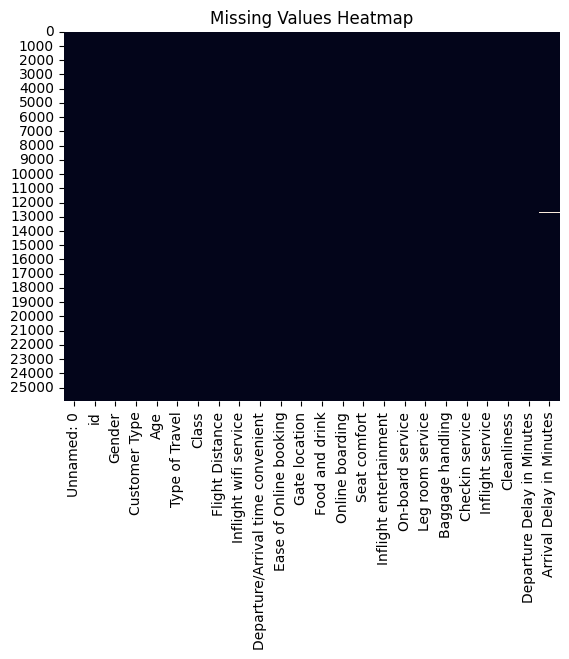

In [87]:
missing = X.isnull().sum()
print("Missing values per column:", missing[missing > 0])
sns.heatmap(X.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# 5. Exploratory Data Analysis

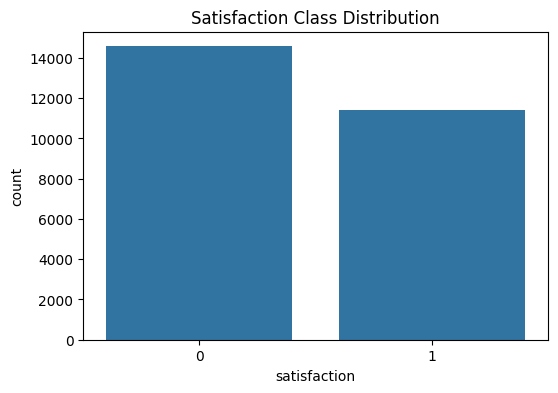

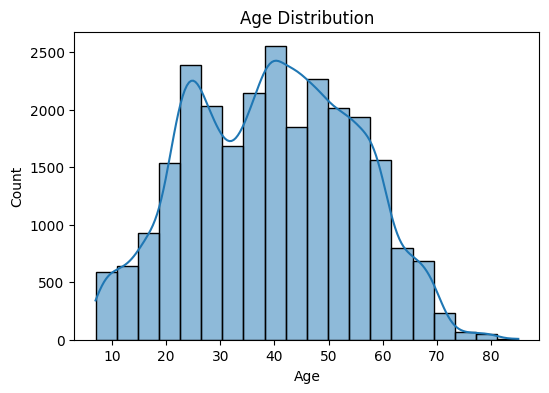

In [68]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Satisfaction Class Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(data['Age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

## 6. Preprocessing
Identify categorical and numerical columns

In [ ]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Pipelines
cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('categorical', cat_pipeline, cat_cols),
    ('numerical', num_pipeline, num_cols)
])

## 7. Train/Test Split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (20780, 24)
Test shape: (5196, 24)




## 8. Pipeline with PCA & SMOTE


In [72]:
model_pipeline = ImbPipeline([
    ('trans', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=20)),
    ('classifier', Perceptron())
])

In [58]:
model_pipeline.fit(X_train,y_train)

,steps,"[('trans', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('categorical', ...), ('numerical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for format

## 9. Grids and Configurations

In [ ]:
sampler_configs = [
    {'sampler': [None]},
    {
        'sampler': [SMOTE(k_neighbors=3, random_state=42)],
        'sampler__sampling_strategy': ['minority', 0.8, 1.0]
    },
    {
        'sampler': [RandomOverSampler(random_state=42)],
        'sampler__sampling_strategy': ['minority', 0.8, 1.0]
    }
]

dim_reduction_configs = [
    {'dim_reduction': [None]},
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [10, 20, 30]
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(
            solver='liblinear',
            max_iter=2000
        )],
        'classifier__C': loguniform(0.001, 100),
        'classifier__class_weight': [None, 'balanced']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5]
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50,100]
    }
]


In [74]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

## 10. Cross Validation

In [75]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

In [76]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=0)

In [77]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

SMOTE(k_neighbors=3, random_state=42, sampling_strategy=0.8)
None
RandomForestClassifier(random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.9556048834628191
----------
RandomOverSampler(random_state=42, sampling_strategy=0.8)
None
RandomForestClassifier(n_estimators=50, random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs'

## 11. Final Model Construction

In [78]:
final_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('sampler', SMOTE(
        k_neighbors=3,
        sampling_strategy=0.8,
        random_state=42
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

final_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('categorical', ...), ('numerical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for f

## 12. Evaluation

In [81]:
y_pred = final_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2915
           1       0.96      0.95      0.95      2281

    accuracy                           0.96      5196
   macro avg       0.96      0.96      0.96      5196
weighted avg       0.96      0.96      0.96      5196



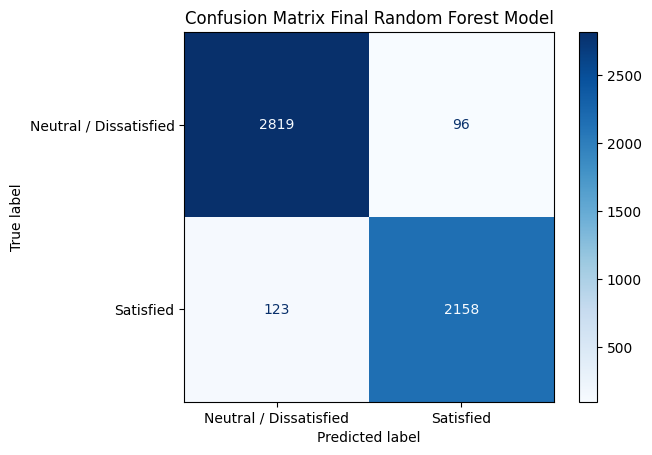

In [83]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Neutral / Dissatisfied", "Satisfied"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix Final Random Forest Model")
plt.show()

## 13. Final Conclusion

The final Random Forest model combined with SMOTE oversampling achieved strong generalization performance on the test set.
The confusion matrix indicates balanced classification of both satisfied and dissatisfied passengers.